In [ ]:
!pip install -U --q langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

#### **API 키 설정**

In [2]:
from dotenv import load_dotenv

load_dotenv()

## Agentic RAG가 집중한 기존 RAG의 문제점

기존 Naive RAG의 경우, 사용자의 질문이 들어왔을 때 인덱싱된 문서가 벡터 DB내에 저장이 되어있고. 그 안에서 검색해왔을 때
그 검색된 문서가 사용자의 질문을 해결할 수 있는 그런 문서가 아닌경우에도 Retrieval 단계를 거치고 답변에 활용하는 모습을 보인다.

이러한 부분들로 인해서 환각현상이 일어나고 크게 두 가지의 문제점으로 나누어서 볼 수 있다.

첫번째는 사실 벡터DB 검색을 통해서 사용자의 질문에 답변할 필요가 없는 경우에도 Retrieval 단계를 거치는 문제.
두번째는 검색된 문서가 사용자의 질문과 관련성이 적더라도 답변 생성에 활용하는 문제점이 있다.

예를 들어 첫 번째 문제 같은 경우에는 "대한민국 2023년 최저 시급은 얼마인가?" 에 대한 질문에는 LLM이 사전학습된 데이터 내에서 답변할 수 있는 수준의 질문 이다.

근데 이런 경우에도 Naive RAG는 이 질문을 벡터 DB의 다양한 문서들과 비교해서 유사한 문서들을 뽑아내고 그것을 기반으로 답변을 하는 과정속에서 검색된 문서만을 참고해서 답변하기 때문에
인사규정 DB를 참고한 경우에는 이러한 질문에 답변을 하지 못하는 모습도 확인할 수있다.

두번째 문제는 같은 경우는 "여름 휴가는 며칠 주어지나요?" 질문을 했을 때, 인사규정 DB내에서 문서들을 쭉 검색했을 때 이와 관려된 문서를 찾을 수가 없는 경우에도 
어떻게든 임베딩 유사도가 가장 높은 것들을 몇개 뽑아주기 때문에 이것을 기반으로 LLM이 답변을 생성하는 과정속에서 환각현상이 일어날 수도 있다. 라고 볼 수 있다.

즉. 첫번째 문제는 불필요하게 리트리버가 일어나는 문제로 볼 수 있고,
두번째 문제는 관련되지 않는 문서로 인해서 LLM이 답변하는데 있어서 환각현상이 일어나는 문제라고 볼 수 있다.

#### **WebBaseLoader로 웹페이지 내 텍스트 Document 객체로 불러오기**

웹페이지, 즉 여러 URL에 있는 페이지나 텍스트들을 WebBaseLoader로 가져온다.

In [19]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls] # 여러 url들을 WebBaseLoader로 불러와서 그 안에있는 텍스트 들을 docs에 리스트 형태로 저장
docs_list = [item for sublist in docs for item in sublist] # docs안에 있는 것들을 저장해서 docs_list로 내보내기
docs_list

# 아래 결과를 보면 metadata와 함께 page_content가 나오는 걸 확인할 수 있고,
# 3개의 웹페이지에 대한 텍스트들을 모두 불어온 걸 볼 수 있다.


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Auton

#### **Chroma 벡터 DB에 임베딩 저장하기**

웹페이지 텍스트들을 잘라 저장해서 사용

In [22]:
# RecursiveCharacterTextSplitter를 통해서 길게 불러온 웹페이지 텍스트들을 100개씩 자름.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)
chroma = Chroma() # 크로마DB에 저장
# Add to vectorDB
# from_documents함수를 통해 vectorDB에다 임베딩 함수로 텍스트들을 임베딩 데이터로 변환하여 밀어넣기
vectorstore = chroma.from_documents(
    documents=doc_splits, # 위에서 docs_list로 documents 객체들을 가지고 있는 리스트를 미리 선언을 했기때문에 그대로 넣어주면됨
    collection_name="rag-chroma", # collection_name은 크로마db로 저장을하면 로컬환경 내에 폴더 형태로 이 크로마 벡터db가 저장이 된다. (doc_splits를 임베딩으로 변환후 저장할 폴더 이름을 rag-chroma 라고 선언 해준것. 폴더이름은 자유롭게 수정가능)
    embedding=OpenAIEmbeddings(), # 임베딩은 OpenAIEmbeddings 활용
)
retriever = vectorstore.as_retriever() # vectorstore 선언이 되면 as_retriever로 변환

#### **Retriever를 도구로 저장하기**

위에서 선언한 retriever를 Tool로 만들기

In [24]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts", # 리트리버의 이름
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.", # 리트리버의 설명
)

tools = [retriever_tool] # 리스트 형태로 담아 tools에 저장

#### **AgentState 선언하기**

In [26]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# 그래프 내에서 정보를 주고 받을 때 어떤 툴로 주고 받을지에 대해서 AgentState로 저장.
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] # AgentState는 BaseMessage들을 Sequence(순서)하게 저장할거고, add_messages를 통해서 메세지들이 누적해서 쌓이게끔 설정

#### **문서 관련성 검토 함수 정의하기**

In [28]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition

# 문서 관련성 검토 함수를 정의하기 위해서는 아래의 것들을 전부다 선언해줘야함

# grade_documents를 가져올건데 반환값은 "generate" 또는 "rewrite"가 된다. 라고 명시
def grade_documents(state) -> Literal["generate", "rewrite"]:
    # docString으로 이 노드가 무슨 역할을 하는지 설명
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    # grade_documents 함수가 실행이 되면 디버깅 메세지 출력
    print("---CHECK RELEVANCE---") 

    # Data model
    # 정해진 틀로써 이 답변을 내놓도록 해야 grade_documents 함수가 분기로직을 수행할 수가 있는데, 
    # 즉 어떤 값이 들어왔을 때 정해진 두개중에 한가지에 값만 내놓도록 만들어주기 위해서 이 class값을 선언한다.
    # 파이던틱 클래스 라고해서 파이던틱한 구조를 가지도록 스트럭쳐를 하나 만들어주기 위한 클래스다.
    class grade(BaseModel):  # 클래스의 이름은 grade고, 파이던틱 구조를 상속받기 위해서 BaseModel을 넣어줌
        """Binary score for relevance check.""" # 이 스트럭처가 무엇을 의미하는지 docString으로 설정
        binary_score: str = Field(description="Relevance score 'yes' or 'no'") # binary_score키 값을 가질거고 이곳에 해당하는 value값은 yes또는no 라고 description을 Field에다 넣어주면 됨

    # LLM 설정 (gpt-4o-mini모델 활용) 비용 내기 싫으면 올라마 같은 오픈소스 사용해도됨
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    # LLM with tool and validation (도구 및 검증을 갖춘 LLM)
    llm_with_tool = model.with_structured_output(grade) # with_structured_output함수에다가 grade클래스를 넣어 모델의 답변값이 binary_score키 값을 가지고 그곳에 해당하는 value가 이렇게 된다. 라고 명시를 해줌

    # grade를 제대로 수행할 수 있게끔 prompt를 만들어주기 (지금 여긴 context와 question 두개의 매개변수가 들어감)
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"], # 명시를 해주기 위해 input_variables에 설정
    )

    # Chain (프롬프트와 LLM이 완성되면 체인으로 묶어줌)
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 메세지 값을 넣어 invoke를 한 결과값이 나오면
    scored_result = chain.invoke({"question": question, "context": docs})

    # binary_score값을 score에 저장해서
    score = scored_result.binary_score 

    # grade가 yes라고 판단하면 generate 모드로 가도록 하고 (즉. 문서와 관련성이 있으면 generate로 가고)
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    # 그렇지 않으면 rewrite로 가게 만듬 (문서와 관련성이 없으면 질문을 재작성 하는 노드로 보냄)
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

C:\Users\user\anaconda3\envs\fastcampus\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


#### **사용자와 상호작용하는 에이전트 함수 정의하기**

In [30]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

#### **질문 재작성 함수 정의하기**

In [32]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


#### **답변 생성 함수 정의하기**

In [34]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

C:\Users\user\anaconda3\envs\fastcampus\Lib\site-packages\langsmith\client.py:312: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


C:\Users\user\anaconda3\envs\fastcampus\Lib\site-packages\langsmith\client.py:5519: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


#### **그래프 구축하기**

In [36]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

#### **그래프 시각화**

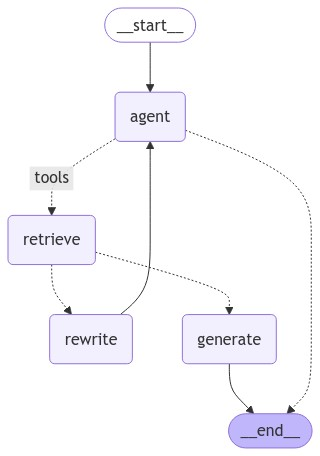

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### **그래프 실행해보기**

In [49]:
query_1 = "agent memory이 무엇인가요?"
query_2 = "Lilian Weng은 agent memory를 어떤 것에 비유했나요?"

In [53]:
import pprint

inputs = {"messages": [("user", query_2)]}

for output in graph.stream(inputs,{"recursion_limit":10}): # recursion_limit은 그래프의 노드들이 총 몇번까지 실행 될것인지 설정
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

# query_2 질문은 마지막에 에러가 나는것을 볼 수 있다.
# 사용자의 질문이 들어왔을때 벡터db내에 문서를 검색한 결과가 사용자의 질문에 계속해서 문제를 해결할 수 없는 경우에
# 즉 질문을 아무리 재작성해도 벡터db내에 관련된 정보를 찾을 수 없을 때 일어나는 무한루프 문제이다.

# Agentic RAG도 완벽한 로직은 아니다.
# 어떤 사용자의 질문에도 LLM이 완전한 대답을 할 수 있는 그런 시스템이 아니기 때문에 반드시 이 시스템을 활용한다면 recursion_limit을 넣어 반복되는 횟수를 제한 시켜야함

---CALL AGENT---
Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_NY3Q6dApHP8kwjGJnszUouIG', 'function': {'arguments': '{"query":"agent memory 비유"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9'}, id='run-8999b558-d0e6-433f-bffe-286d8fd831e6-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'agent memory 비유'}, 'id': 'call_NY3Q6dApHP8kwjGJnszUouIG', 'type': 'tool_call'}])]}

---

---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
Output from node 'retrieve':
---
{'messages': [ToolMessage(content='Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.